# Предсказание показаний состояния пациента

### Данные
Данные в файле covid_flow.pkl включают поток пациентов с подтвержденным COVID-19 в ковидные стационары НИМЦ
Алмазова, Санкт-Петербург.

Датасет включает 1992 случая стационарного лечения COVID-19. Данные включают

Многомерные временные ряды, описывающие состояние пациента (интервал неделя)
План лечения (препараты и процедуры) для каждого пациента
Исходы лечения

### Переменные 
_stat_control – стационарные признаки, которые описывают контролирующий
процесс и не меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 препарата в план лечения)

_dinam_control – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 процедуры в план лечения)

_stat_fact – стационарные признаки, которые описывают контролируемый процесс
и не меняются (в covid_flow это признаки, описывающие пациентов, пол, возраст, и
все остальное что не меняется)

_dinam_fact – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это признаки описывающие состояние
пациентов, например температура, % поражения легких и другое)

t_point – индикатор временного интервала. Вся длительность процесса разбита на
равные интервалы времени, t_point – метка интервала.

end_epizode – индикатор конца процесса, 0 – процесс лечения не окончен в
данном t_point, 1 – окончен

case (index) – уникальный идентификатор наблюдения (процесса), пример –
«GACAk+Q»

long_observation_tar – длинна процесса

current_process_duration – текущая длинна процесса (на момент t_point)

outcome_tar – исход лечения, 1- летальный, 0 – выздоровление.

### Задача
Прогноз значения индикаторов состояния пациента (результаты анализов)

Таргеты – признаки с префиксами _dinam_fact.
Факторы – предыдущие значения (кроме _tar), текущее состояние

На выходе получаем класс, который умеет принимать информацию о прошлых состояниях пациента, и прогнозировать следующее.

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Input, Flatten, concatenate
from keras import Model
from keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

### Load data

In [51]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df.set_index(["case", "t_point"], inplace=True)
df = df.sort_values(["case", "t_point"])

In [52]:
df.iloc[:, 43:47]

трансфузия_dinam_control  оксигенотерапия_dinam_control  \
case    t_point                                                            
GACAAcY 0                               0                              1   
        1                               0                              1   
        2                               0                              1   
        3                               0                              1   
GACAAnf 0                               0                              0   
...                                   ...                            ...   
GACBB;O 0                               0                              0   
        1                               0                              0   
GACXAAB 0                               0                              0   
        1                               0                              0   
        2                               0                              0   

                 НИВЛ_dinam_control  ИВЛ_dinam_control  
case    t_point                                         
GACAAcY 0                         0                  0  
        1                         0                  0  
        2                         0                  0  
        3                         0                  0  
GACAAnf 0                         0                  0  
...                             ...                ...  
GACBB;O 0                         0                  0  
        1                         0                  0  
GACXAAB 0                         0                  0  
        1                         0                  0  
        2                         0                  0  

[6188 rows x 4 columns]

# Predict next period by last one

In [53]:
dinam_fact_df = df.iloc[:,29:42]
dinam_fact_df = dinam_fact_df.sort_values(["case", "t_point"])
dinam_fact_df

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                          36.7                   1.93   
        1                          36.3                   2.00   
        2                          36.6                   2.13   
        3                          36.5                   2.12   
GACAAnf 0                           NaN                   1.21   
...                                 ...                    ...   
GACBB;O 0                          36.9                   1.22   
        1                          36.5                   1.65   
GACXAAB 0                          36.5                   1.11   
        1                          36.9                   1.60   
        2                          36.6                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90            74.0            24.0   
        1                 25.70            71.0            19.0   
        2                 32.00             NaN            18.0   
        3                 27.00            71.0            18.0   
GACAAnf 0                 20.70            55.0            22.0   
...                         ...             ...             ...   
GACBB;O 0                 22.34            54.0            18.0   
        1                244.03             NaN            17.0   
GACXAAB 0                 21.80             NaN             NaN   
        1                 60.80            75.0            16.0   
        2                 17.20             NaN            15.0   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                             15.30   
        1                             12.10   
        2                               NaN   
        3                               NaN   
GACAAnf 0                              7.80   
...                                     ...   
GACBB;O 0                              1.43   
        1                              3.78   
GACXAAB 0                              4.50   
        1                              1.10   
        2                              9.30   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

### Data preparation 

Our suggestion is to divide history by 3 periods

Count of patients: 1992


<AxesSubplot: >

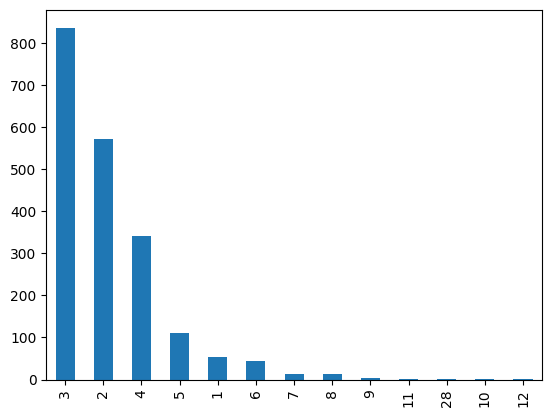

In [54]:
print(f"Count of patients: {dinam_fact_df.index.levels[0].size}")
dinam_fact_df.groupby(["case"]).size().value_counts(sort=True).plot(kind="bar")

#### Scaling and imputing

Scale values as (x-min(x))/(max(x)-min(x))

Impute NaN values using MICE method with IterativeImputer on Linear regression as estimator 

Divide on train, test, validation splits

#### Function which shows results of model

In [55]:
# Function which shows results of model
def show_results(X_test, y_test, model, history, batch_size=None, sample_num = 0):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["train loss", "validation loss"])

    y_pred = model.predict(X_test, batch_size=batch_size, verbose=0)

    r2_scor = r2_score(y_test, y_pred, multioutput="raw_values")
    mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")

    table=[]
    table.append(mse_score)
    table.append(r2_scor)

    df_score = pd.DataFrame(table, ["MSE", "R2"], columns=df.columns[29:42])
    df_score.to_csv("reports/"+model.name+".csv")
    model.save("models/"+model.name)
    display(df_score)
    plt.show()
    

## Train Models

#### Window 1 

In [66]:
import prepare_data_covid as datacovid
(X_train, y_train), (X_test, y_test), (X_val, y_val) = \
datacovid.prepare_dynamic(df_input=df, window=3)
(X_train, y_train), (X_test, y_test), (X_val, y_val) =\
    (X_train[1:], y_train[1:]), (X_test[1:], y_test[1:]), (X_val[2:], y_val[2:])

d:\covid\covid\venv\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


TRAIN shape:  (712, 3, 13)
TEST shape:  (89, 13)
VAL shape:  (89, 13)


#### RNN

Simple RNN with linear activation 

Model: "1_SimpleRNN13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 13)                351       
                                                                 
 dense_51 (Dense)            (None, 13)                182       
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: models/1_SimpleRNN13\assets


INFO:tensorflow:Assets written to: models/1_SimpleRNN13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002136,0.000402,0.000571,0.015473,0.000590,0.001977,0.012118,0.005812,0.012286,0.023296,0.039712,0.000607,0.009393
R2,-0.321181,-12.494303,-0.637816,-0.008205,-1.790344,-1.001625,0.157438,0.107481,0.233345,0.718115,-0.067819,0.000950,-0.049554


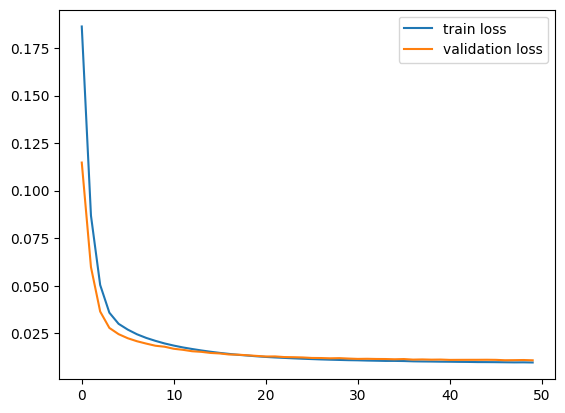

In [67]:
PARAMS_LENGTH = X_train.shape[2]
WINDOW = X_train.shape[1]
model = Sequential(name="1_SimpleRNN13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

Simple RNN without shuffle

Model: "2_SimpleRNN13_shuffle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 13)                351       
                                                                 
 dense_44 (Dense)            (None, 13)                182       
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: models/2_SimpleRNN13_shuffle\assets


INFO:tensorflow:Assets written to: models/2_SimpleRNN13_shuffle\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002950,0.000456,0.000610,0.014417,0.000473,0.003230,0.004677,0.007482,0.007716,0.011769,0.054945,0.000866,0.006230
R2,-0.107334,-17.613601,-1.443556,-0.016548,-1.379545,-0.075033,0.561244,0.053426,0.434508,0.810851,0.003006,-0.053521,0.447954


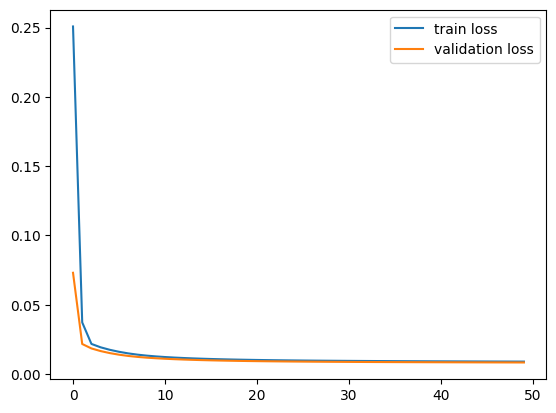

In [59]:
PARAMS_LENGTH = X_train.shape[2]
WINDOW = X_train.shape[1]
model = Sequential(name="2_SimpleRNN13_shuffle")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), shuffle=False, verbose=0)
show_results(X_test, y_test, model, history)

SimpleRNN sigmoid

Model: "3_SimpleRNN13_SigmoidActivation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 13)                351       
                                                                 
 dense_45 (Dense)            (None, 13)                182       
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: models/3_SimpleRNN13_SigmoidActivation\assets


INFO:tensorflow:Assets written to: models/3_SimpleRNN13_SigmoidActivation\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002742,0.000304,0.000148,0.014445,0.000152,0.003054,0.005689,0.007246,0.008675,0.012373,0.055292,0.000826,0.007008
R2,-0.029283,-11.434622,0.408273,-0.018513,0.237126,-0.016210,0.466282,0.083356,0.364210,0.801154,-0.003287,-0.004208,0.378966


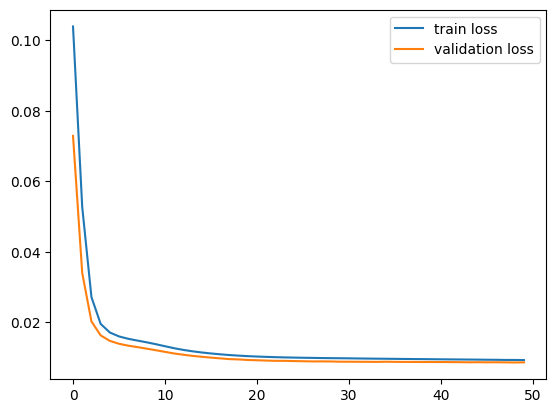

In [60]:
PARAMS_LENGTH = X_train.shape[2]
WINDOW = X_train.shape[1]
model = Sequential(name="3_SimpleRNN13_SigmoidActivation")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="sigmoid"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

SimpleRNN with Tanh activation

Model: "4_SimpleRNN13_TanhActivation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 13)                351       
                                                                 
 dense_46 (Dense)            (None, 13)                182       
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: models/4_SimpleRNN13_TanhActivation\assets


INFO:tensorflow:Assets written to: models/4_SimpleRNN13_TanhActivation\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002722,0.000195,0.000157,0.014171,0.000185,0.002859,0.004917,0.007012,0.007892,0.010941,0.055014,0.000767,0.006144
R2,-0.021914,-6.971328,0.368971,0.000771,0.071577,0.048513,0.538737,0.112889,0.421611,0.824165,0.001767,0.066664,0.455514


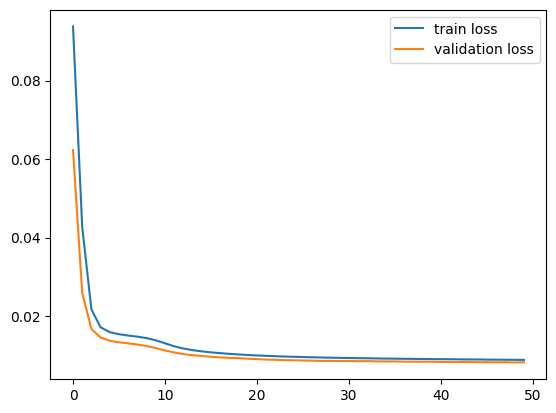

In [61]:
PARAMS_LENGTH = X_train.shape[2]
WINDOW = X_train.shape[1]
model = Sequential(name="4_SimpleRNN13_TanhActivation")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="sigmoid"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),  verbose=0)
show_results(X_test, y_test, model, history)

### LSTM

LSTM 13 units and linear

Model: "5_LSTM13_Linear"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 13)                1404      
                                                                 
 dense_47 (Dense)            (None, 13)                182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models/5_LSTM13_Linear\assets


INFO:tensorflow:Assets written to: models/5_LSTM13_Linear\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002740,0.000099,0.000133,0.014368,0.000149,0.002166,0.004555,0.005723,0.007254,0.009858,0.053774,0.000630,0.005068
R2,-0.028677,-3.030961,0.465947,-0.013145,0.251866,0.279321,0.572679,0.276050,0.468416,0.841562,0.024258,0.233733,0.550928


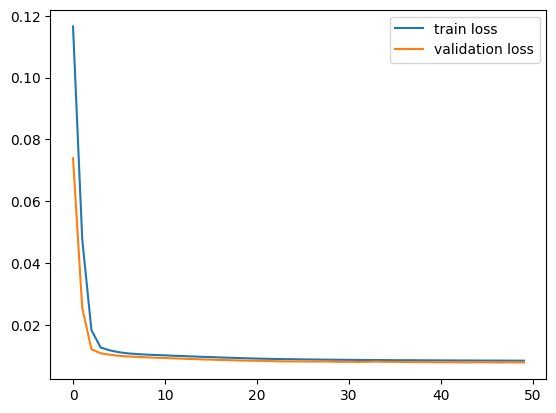

In [62]:
model = Sequential(name="5_LSTM13_Linear")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

Model: "5_LSTM13_Sigmoid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 13)                1404      
                                                                 
 dense_48 (Dense)            (None, 13)                182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models/5_LSTM13_Sigmoid\assets


INFO:tensorflow:Assets written to: models/5_LSTM13_Sigmoid\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002764,0.000073,0.000159,0.014209,0.000130,0.003044,0.005752,0.006962,0.008923,0.012354,0.054872,0.000781,0.005954
R2,-0.037539,-2.002018,0.363615,-0.001913,0.348929,-0.012968,0.460377,0.119314,0.346052,0.801450,0.004345,0.049462,0.472370


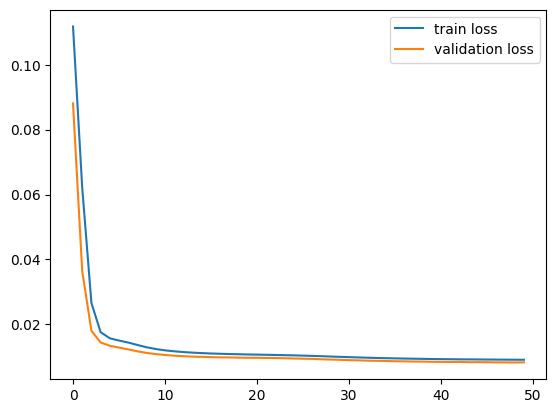

In [63]:
model = Sequential(name="5_LSTM13_Sigmoid")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="sigmoid"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

Model: "5_LSTM13_Tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 13)                1404      
                                                                 
 dense_49 (Dense)            (None, 13)                182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models/5_LSTM13_Tanh\assets


INFO:tensorflow:Assets written to: models/5_LSTM13_Tanh\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002705,0.000289,0.000167,0.013888,0.00014,0.001758,0.004728,0.005986,0.007209,0.011722,0.054294,0.000657,0.005173
R2,-0.015588,-10.823242,0.332322,0.020699,0.29715,0.414919,0.556435,0.242666,0.471660,0.811610,0.014830,0.201299,0.541573


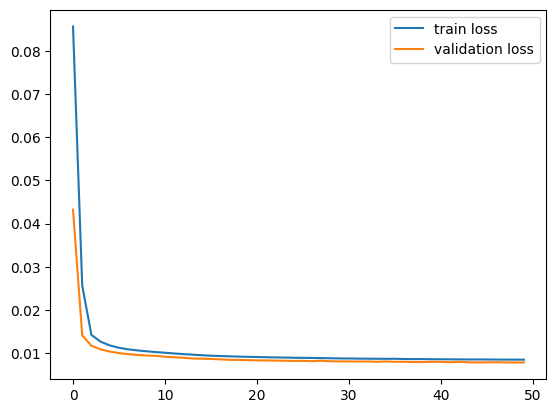

In [64]:
model = Sequential(name="5_LSTM13_Tanh")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="tanh"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

LSTM with batch

In [65]:
BATCH_SIZE=8

model = Sequential(name="6_LSTM13_Batch8")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "6_LSTM13_Batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (8, 13)                   1404      
                                                                 
 dense_50 (Dense)            (8, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


InvalidArgumentError: Graph execution error:

Specified a list with shape [8,13] from a tensor with shape [4,13]
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
	 [[6_LSTM13_Batch8/lstm_23/PartitionedCall]] [Op:__inference_train_function_2102012]

Model: "7_LSTM13_Batch4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (4, 13)                   1404      
                                                                 
 dense_8 (Dense)             (4, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models/7_LSTM13_Batch4\assets


INFO:tensorflow:Assets written to: models/7_LSTM13_Batch4\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002170,0.000065,0.000244,0.006685,0.000106,0.003049,0.006459,0.008500,0.010167,0.000052,0.074049,0.000547,0.006371
R2,0.023473,0.962037,0.330476,0.029307,0.451678,0.304258,0.596424,0.219306,0.346878,0.998678,0.019200,0.252506,0.566755


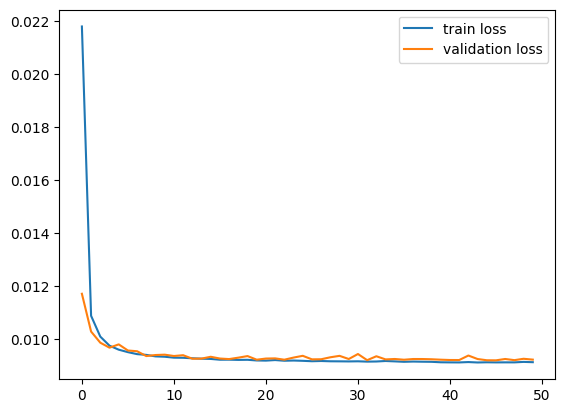

In [ ]:
BATCH_SIZE=4
model = Sequential(name="7_LSTM13_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "8_LSTM13_Batch2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (2, 13)                   1404      
                                                                 
 dense_9 (Dense)             (2, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models/8_LSTM13_Batch2\assets


INFO:tensorflow:Assets written to: models/8_LSTM13_Batch2\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002154,0.000080,0.000309,0.007217,0.000107,0.003115,0.006540,0.008358,0.010067,0.000277,0.073894,0.000693,0.006459
R2,0.031089,0.952999,0.153167,-0.047959,0.443186,0.289224,0.591366,0.232340,0.353273,0.992936,0.021255,0.052636,0.560755


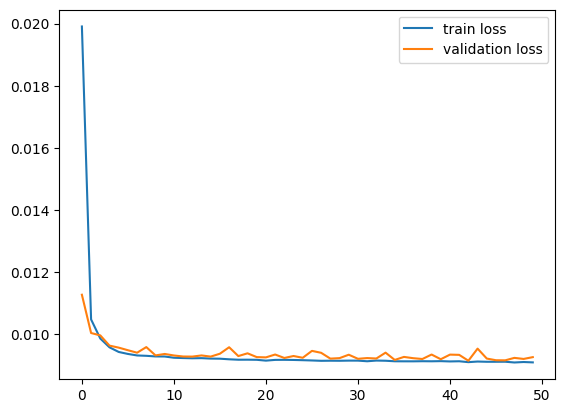

In [ ]:
BATCH_SIZE=2
model = Sequential(name="8_LSTM13_Batch2")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "9_LSTM13_Batch1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (1, 13)                   1404      
                                                                 
 dense_10 (Dense)            (1, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models/9_LSTM13_Batch1\assets


INFO:tensorflow:Assets written to: models/9_LSTM13_Batch1\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002155,0.000062,0.000256,0.006531,0.000118,0.003108,0.006592,0.008268,0.010274,0.000065,0.073946,0.000546,0.007478
R2,0.030597,0.963648,0.298375,0.051768,0.386230,0.290866,0.588081,0.240600,0.339993,0.998331,0.020568,0.253508,0.491431


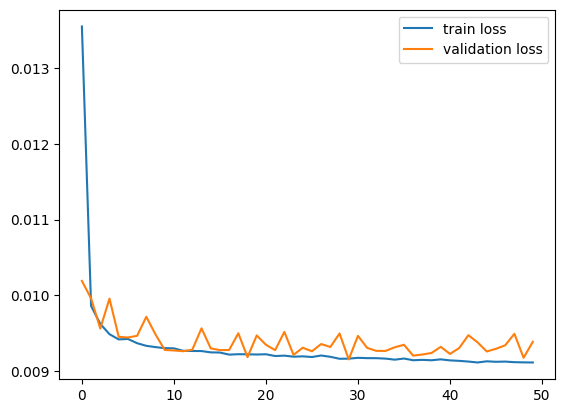

In [ ]:
BATCH_SIZE=1
model = Sequential(name="9_LSTM13_Batch1")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

LSTM with more unit states

Model: "10_LSTM32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 32)                5888      
                                                                 
 dense_11 (Dense)            (None, 13)                429       
                                                                 
Total params: 6,317
Trainable params: 6,317
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models/10_LSTM32\assets


INFO:tensorflow:Assets written to: models/10_LSTM32\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002179,0.000064,0.000246,0.006607,0.000112,0.003077,0.006420,0.008324,0.010086,0.000174,0.074568,0.000571,0.006458
R2,0.019465,0.962469,0.325318,0.040663,0.418316,0.297942,0.598869,0.235513,0.352032,0.995572,0.012327,0.219185,0.560798


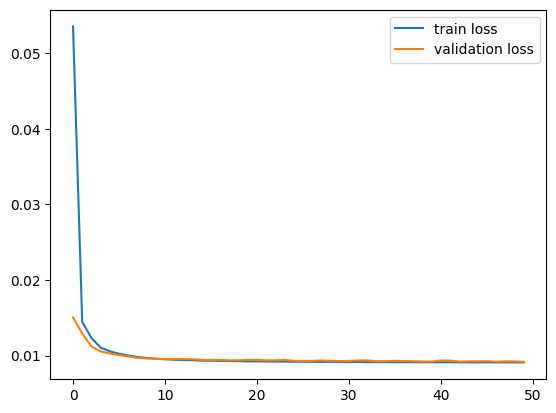

In [ ]:
model = Sequential(name="10_LSTM32")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

LSTM to LSTM

Model: "LSTM64xLSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 32)             5888      
                                                                 
 lstm_9 (LSTM)               (None, 13)                2392      
                                                                 
 dense_12 (Dense)            (None, 13)                182       
                                                                 
Total params: 8,462
Trainable params: 8,462
Non-trainable params: 0
_________________________________________________________________
None


INFO:tensorflow:Assets written to: models/LSTM64xLSTM13\assets


INFO:tensorflow:Assets written to: models/LSTM64xLSTM13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002268,0.000163,0.000253,0.006600,0.000192,0.003816,0.006411,0.008291,0.010065,0.000069,0.074462,0.000588,0.006423
R2,-0.020358,0.904354,0.307206,0.041643,0.003351,0.129258,0.599403,0.238547,0.353374,0.998227,0.013740,0.195869,0.563177


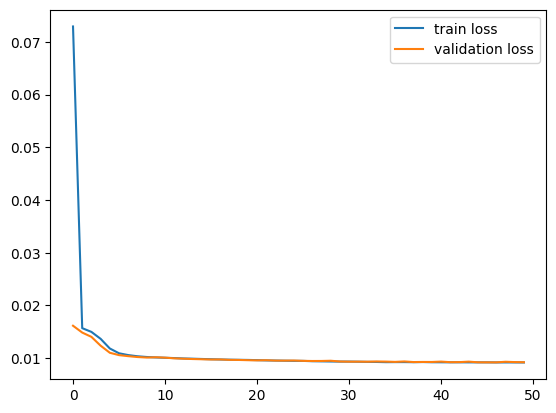

In [ ]:
model = Sequential(name="LSTM64xLSTM13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

Model: "LSTM64xLSTM13_Batch4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (4, 1, 32)                5888      
                                                                 
 lstm_11 (LSTM)              (4, 13)                   2392      
                                                                 
 dense_13 (Dense)            (4, 13)                   182       
                                                                 
Total params: 8,462
Trainable params: 8,462
Non-trainable params: 0
_________________________________________________________________
None


INFO:tensorflow:Assets written to: models/LSTM64xLSTM13_Batch4\assets


INFO:tensorflow:Assets written to: models/LSTM64xLSTM13_Batch4\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002244,0.000076,0.000248,0.006549,0.000131,0.003176,0.006739,0.008317,0.010833,0.000284,0.074875,0.000584,0.006468
R2,-0.009593,0.955228,0.320374,0.049045,0.321895,0.275321,0.578932,0.236087,0.304088,0.992747,0.008263,0.201486,0.560124


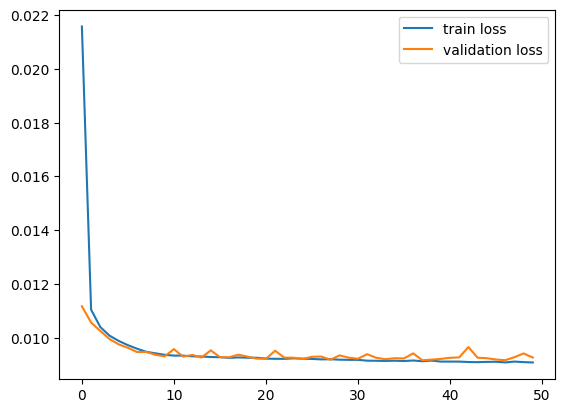

In [ ]:
BATCH_SIZE=4
model = Sequential(name="LSTM64xLSTM13_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "GRU13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 13)                1092      
                                                                 
 dense_14 (Dense)            (None, 13)                182       
                                                                 
Total params: 1,274
Trainable params: 1,274
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models/GRU13\assets


INFO:tensorflow:Assets written to: models/GRU13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002174,0.000071,0.000262,0.006586,0.000152,0.003277,0.006449,0.008286,0.010146,0.000079,0.074243,0.000600,0.006398
R2,0.021957,0.958153,0.281484,0.043725,0.209170,0.252250,0.597071,0.239014,0.348165,0.997988,0.016631,0.179929,0.564878


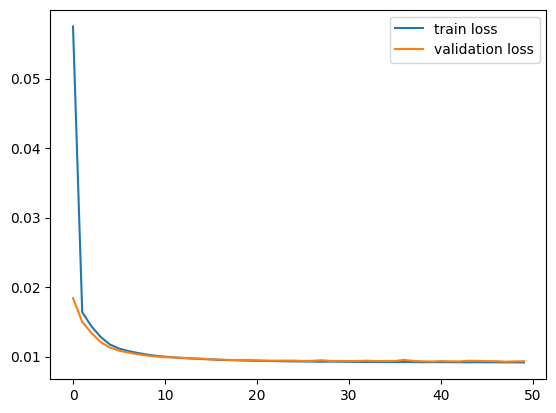

In [ ]:
model = Sequential(name="GRU13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(GRU(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

Model: "GRU13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (4, 13)                   1092      
                                                                 
 dense_15 (Dense)            (4, 13)                   182       
                                                                 
Total params: 1,274
Trainable params: 1,274
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models/GRU13\assets


INFO:tensorflow:Assets written to: models/GRU13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002163,0.000077,0.000261,0.006591,0.000121,0.003140,0.006505,0.008529,0.010182,0.00006,0.074437,0.000692,0.006469
R2,0.027037,0.954863,0.285565,0.042936,0.372161,0.283517,0.593547,0.216658,0.345884,0.99846,0.014063,0.054666,0.560034


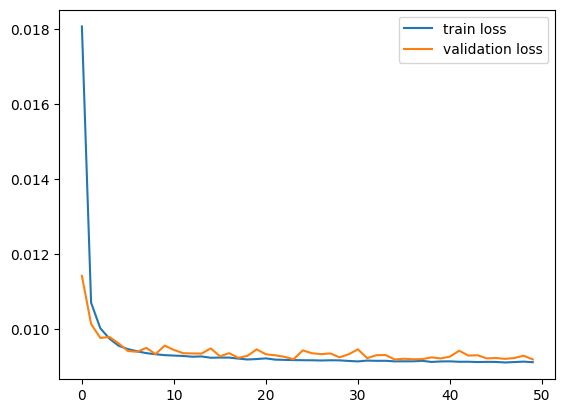

In [ ]:
BATCH_SIZE = 4
model = Sequential(name="GRU13")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(GRU(PARAMS_LENGTH, return_sequences=False,))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0, batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history , batch_size=BATCH_SIZE)

FNN

Model: "Faltten2Layers_Window1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 13)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                448       
                                                                 
 dense_17 (Dense)            (None, 13)                429       
                                                                 
Total params: 877
Trainable params: 877
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
105/105 [==============================] - 1s 3ms/step - loss: 0.0570 - val_loss: 0.0167
Epoch 2/50
105/105 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0123
Epoch 3/50
105/105 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 4/50

INFO:tensorflow:Assets written to: models/Faltten2Layers_Window1\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002296,0.000104,0.000332,0.006639,0.000114,0.003157,0.006543,0.008255,0.010157,0.000117,0.074058,0.000557,0.006695
R2,-0.033063,0.938875,0.090778,0.036064,0.409940,0.279670,0.591179,0.241775,0.347465,0.997004,0.019088,0.239481,0.544706


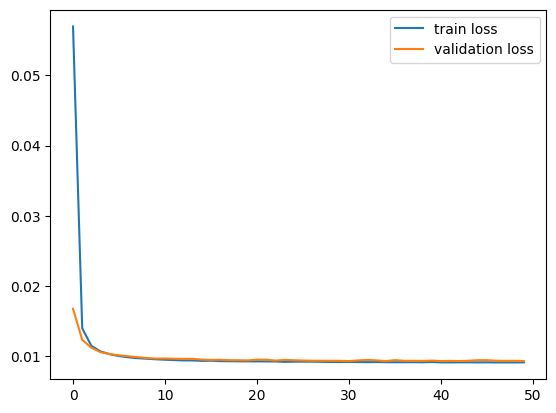

In [ ]:
PARAMS_LENGTH = X_train.shape[2]
WINDOW=1
model = Sequential(name="Faltten2Layers_Window1")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Faltten2Layers_Window1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 13)                0         
                                                                 
 dense_18 (Dense)            (None, 32)                448       
                                                                 
 dense_19 (Dense)            (None, 32)                1056      
                                                                 
 dense_20 (Dense)            (None, 13)                429       
                                                                 
Total params: 1,933
Trainable params: 1,933
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
105/105 [==============================] - 1s 3ms/step - loss: 0.0436 - val_loss: 0.0124
Epoch 2/50
105/105 [==============================] - 0s 2ms/step - loss: 

INFO:tensorflow:Assets written to: models/Faltten2Layers_Window1\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002239,0.000119,0.000274,0.006691,0.000135,0.003186,0.006646,0.008318,0.010136,0.000079,0.074319,0.000620,0.006554
R2,-0.007565,0.929794,0.248081,0.028496,0.299173,0.272864,0.584713,0.236024,0.348863,0.997981,0.015629,0.152775,0.554269


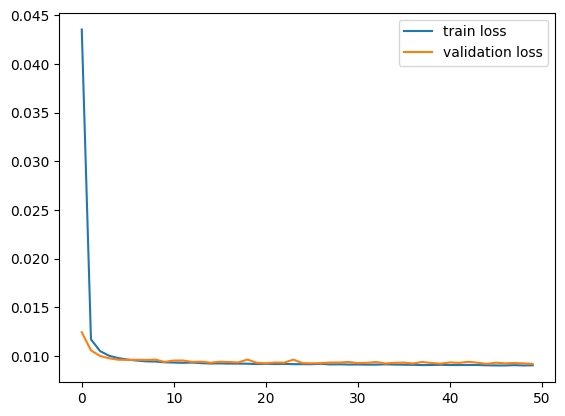

In [ ]:
PARAMS_LENGTH = X_train.shape[2]
BATCH_SIZE=4
model = Sequential(name="Faltten2Layers_Window1")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

## Train with static parameters


Lets define new function for splitting

In [ ]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = \
datacovid.prepare_data_with_static(df_input=df, window=1)
(X_train, y_train), (X_test, y_test), (X_val, y_val) =\
    (X_train[1:], y_train[1:]), (X_test[1:], y_test[1:]), (X_val[2:], y_val[2:])

Model: "LSTM_StatDynam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 64)                28672     
                                                                 
 dense_21 (Dense)            (None, 13)                845       
                                                                 
Total params: 29,517
Trainable params: 29,517
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
105/105 [==============================] - 3s 10ms/step - loss: 0.0313 - val_loss: 0.0152
Epoch 2/50
105/105 [==============================] - 0s 3ms/step - loss: 0.0133 - val_loss: 0.0122
Epoch 3/50
105/105 [==============================] - 0s 3ms/step - loss: 0.0112 - val_loss: 0.0110
Epoch 4/50
105/105 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0105
Epoch 5/50
105/105 [=======================

INFO:tensorflow:Assets written to: models/LSTM_StatDynam\assets


INFO:tensorflow:Assets written to: models/LSTM_StatDynam\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001796,0.000807,0.000227,0.006596,0.000250,0.001210,0.004754,0.006648,0.007921,0.000882,0.06334,0.000954,0.003999
R2,-0.107056,0.713625,0.148488,0.158812,0.056245,0.534903,0.700533,0.546636,0.586921,0.977347,0.20753,0.224197,0.743088


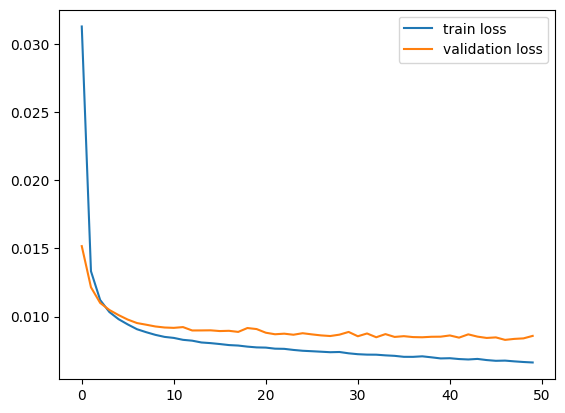

In [ ]:
PARAMS_LENGTH = X_train.shape[2]
TARGET_LENGTH = y_train.shape[1]
WINDOW=1
name = "LSTM_StatDynam"
model = Sequential(name=name)
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model_lstm = model
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()
history = model_lstm.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model_lstm, history)

Here we will take dynamic and static params aparted

In [ ]:
D_train = X_train[:, :, 29:]
S_train = X_train[:, 0, 0:29]
S_train = np.hstack([S_train, X_train[:, 0, 42:43]])
D_val = X_val[:, :, 29:]
S_val = X_val[:, 0, :29]
S_val = np.hstack([S_val, X_val[:, 0, 42:43]])


Model: "StaticDense_DynamicLSTM_oneLayer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 1, 18)]      0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 lstm_13 (LSTM)                 (None, 40)           9440        ['input_21[0][0]']               
                                                                                                  
 dense_22 (Dense)               (None, 16)           496         ['input_20[0][0]']               
                                                                   

INFO:tensorflow:Assets written to: models/StaticDense_DynamicLSTM_oneLayer\assets


INFO:tensorflow:Assets written to: models/StaticDense_DynamicLSTM_oneLayer\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002217,0.000082,0.000365,0.008355,0.000197,0.001032,0.004821,0.006967,0.007794,0.002259,0.078145,0.000852,0.005256
R2,0.055637,0.964258,0.026112,0.216516,0.210248,0.526179,0.718726,0.458621,0.543102,0.952665,0.060491,0.113034,0.677090


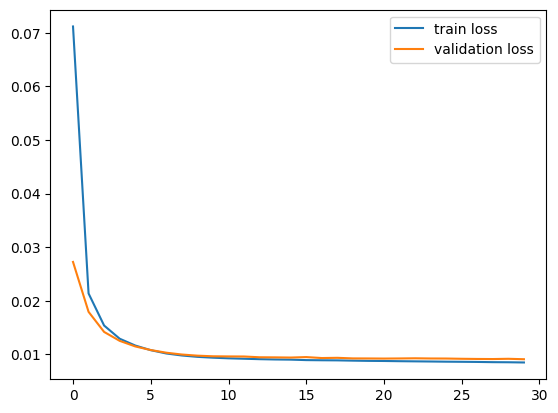

In [ ]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
WINDOW=1
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(40, return_state=False)(input_dinamic)
result_layer = Dense(13, activation='linear')(concatenate([lstm_layer, dense_layer]))
model = Model(name="StaticDense_DynamicLSTM_oneLayer", inputs=[input_static, input_dinamic], outputs=result_layer)
model.summary()
model.compile(optimizer="adam", loss="mse")

history = model.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=30)
show_results([S_val, D_val], y_val, model, history)

Lets use linear activation to compare results

Model: "StaticDense_DynamicLSTM_twoLayers"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 1, 18)]      0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 lstm_14 (LSTM)                 (None, 64)           21248       ['input_23[0][0]']               
                                                                                                  
 dense_24 (Dense)               (None, 32)           992         ['input_22[0][0]']               
                                                                  

INFO:tensorflow:Assets written to: models/StaticDense_DynamicLSTM_twoLayers\assets


INFO:tensorflow:Assets written to: models/StaticDense_DynamicLSTM_twoLayers\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002296,0.000188,0.000326,0.007608,0.000207,0.001535,0.00495,0.006989,0.007753,0.000962,0.062276,0.001001,0.004844
R2,0.022049,0.918530,0.131376,0.286545,0.170433,0.295244,0.71117,0.456901,0.545540,0.979847,0.251270,-0.042290,0.702395


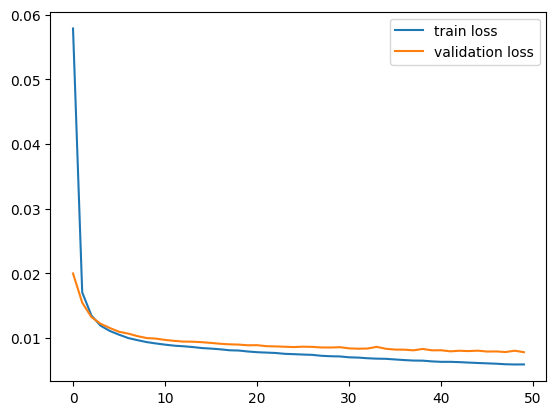

In [ ]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
WINDOW=1
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(32, activation='relu')(input_static)
lstm_layer = LSTM(64, return_state=False)(input_dinamic)
result_layer = Dense(32, activation="relu")(concatenate([lstm_layer, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model = Model(name="StaticDense_DynamicLSTM_twoLayers", inputs=[input_static, input_dinamic], outputs=result_layer)
model.summary()
model.compile(optimizer="adam", loss="mse")
history = model.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=50)
show_results([S_val, D_val], y_val, model, history)

Model: "StaticDense_DynamicGRU"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 1, 18)]      0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 gru_2 (GRU)                    (None, 64)           16128       ['input_25[0][0]']               
                                                                                                  
 dense_27 (Dense)               (None, 32)           992         ['input_24[0][0]']               
                                                                             

INFO:tensorflow:Assets written to: models/StaticDense_DynamicGRU\assets


INFO:tensorflow:Assets written to: models/StaticDense_DynamicGRU\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002250,0.000212,0.000288,0.008242,0.000161,0.000887,0.004566,0.006439,0.007872,0.000223,0.062470,0.000943,0.005037
R2,0.041749,0.908152,0.232175,0.227077,0.354544,0.592711,0.733591,0.499644,0.538583,0.995322,0.248945,0.017394,0.690505


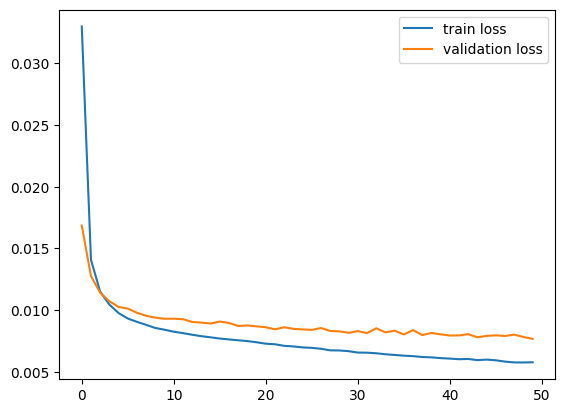

In [ ]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
WINDOW=1
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(32, activation='relu')(input_static)
lstm_layer = GRU(64, return_state=False)(input_dinamic)
result_layer = Dense(32, activation="relu")(concatenate([lstm_layer, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model = Model(name="StaticDense_DynamicGRU", inputs=[input_static, input_dinamic], outputs=result_layer)
model.summary()
model.compile(optimizer="adam", loss="mse")
history = model.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=50)
show_results([S_val, D_val], y_val, model, history)

## Dynamic windows

#### Window size: 1

In [ ]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = datacovid.prepare_data_with_static(df, window=1)
D_train, S_train, D_val, S_val, D_test, S_test = datacovid.divide_dynamic_static(X_train, X_test, X_val)
print("Test train shapes:", X_train.shape, X_test.shape)

Test train shapes: (3356, 1, 47) (420, 1, 47)


Model: "SttaicDense_DynamicLSTM_Window1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 1, 18)]      0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 lstm_15 (LSTM)                 (None, 40)           9440        ['input_27[0][0]']               
                                                                                                  
 dense_30 (Dense)               (None, 16)           496         ['input_26[0][0]']               
                                                                    

INFO:tensorflow:Assets written to: models/SttaicDense_DynamicLSTM_Window1\assets


INFO:tensorflow:Assets written to: models/SttaicDense_DynamicLSTM_Window1\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002228,0.000316,0.000353,0.007268,0.000163,0.000865,0.004035,0.008669,0.009099,0.001092,0.072714,0.000971,0.003806
R2,0.045188,0.913390,0.336521,0.020416,0.378668,0.450965,0.751325,0.377915,0.525590,0.982453,0.110881,0.228308,0.748312


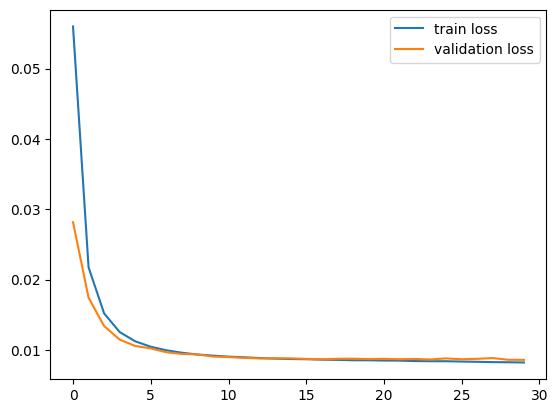

In [ ]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
WINDOW=1
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(40, return_state=False)(input_dinamic)
result_layer = Dense(13, activation='linear')(concatenate([lstm_layer, dense_layer]))
model = Model(name="SttaicDense_DynamicLSTM_Window1", inputs=[input_static, input_dinamic], outputs=result_layer)
model.summary()
model.compile(optimizer="adam", loss="mse")

history = model.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=30)

show_results([S_val, D_val], y_val, model, history)

Model: "Faltten2Layers_Window1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 47)                0         
                                                                 
 dense_32 (Dense)            (None, 32)                1536      
                                                                 
 dense_33 (Dense)            (None, 13)                429       
                                                                 
Total params: 1,965
Trainable params: 1,965
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
105/105 [==============================] - 1s 4ms/step - loss: 0.0683 - val_loss: 0.0336
Epoch 2/50
105/105 [==============================] - 0s 3ms/step - loss: 0.0257 - val_loss: 0.0223
Epoch 3/50
105/105 [==============================] - 0s 3ms/step - loss: 0.0189 - val_loss: 0.0179
Epoch 

INFO:tensorflow:Assets written to: models/Faltten2Layers_Window1\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002241,0.000553,0.000232,0.009772,0.000188,0.001157,0.005021,0.007593,0.007755,0.000505,0.064204,0.001021,0.004968
R2,-0.011726,-13.400010,0.303611,0.125600,0.198422,0.114001,0.678477,0.491760,0.489513,0.988872,0.239326,0.138091,0.664983


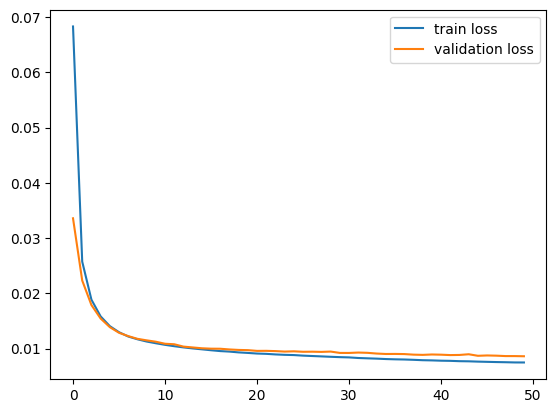

In [ ]:
PARAMS_LENGTH = X_train.shape[2]
TARGET_LENGTH = y_train.shape[1]
WINDOW=1
model = Sequential(name="Faltten2Layers_Window1")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "LSTM64_Window1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 64)                28672     
                                                                 
 dense_34 (Dense)            (None, 13)                845       
                                                                 
Total params: 29,517
Trainable params: 29,517
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
105/105 [==============================] - 4s 16ms/step - loss: 0.0311 - val_loss: 0.0170
Epoch 2/50
105/105 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0132
Epoch 3/50
105/105 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 4/50
105/105 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 5/50
105/105 [=======================

INFO:tensorflow:Assets written to: models/LSTM64_Window1\assets


INFO:tensorflow:Assets written to: models/LSTM64_Window1\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002000,0.000272,0.000259,0.008331,0.000217,0.000824,0.004191,0.007737,0.006915,0.000833,0.061446,0.000982,0.004485
R2,0.096897,-6.082100,0.221823,0.254534,0.075253,0.368906,0.731632,0.482123,0.544848,0.981642,0.272008,0.171282,0.697563


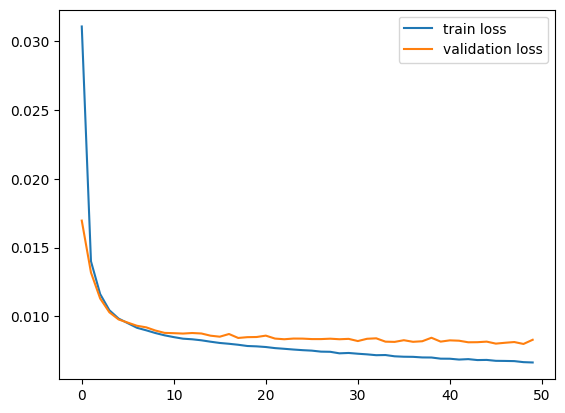

In [ ]:
PARAMS_LENGTH = X_train.shape[2]
TARGET_LENGTH = y_train.shape[1]
WINDOW=1
model = Sequential(name="LSTM64_Window1")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

In [ ]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = datacovid.prepare_data_with_static(df, window=2)
D_train, S_train, D_val, S_val, D_test, S_test = datacovid.divide_dynamic_static(X_train, X_test, X_val)
print("Test train shapes:", X_train.shape, X_test.shape)

Test train shapes: (1805, 2, 47) (226, 2, 47)


Model: "StaticDense_DynamicLSTM_Window2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 2, 18)]      0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 lstm_17 (LSTM)                 (None, 40)           9440        ['input_31[0][0]']               
                                                                                                  
 dense_35 (Dense)               (None, 16)           496         ['input_30[0][0]']               
                                                                    

INFO:tensorflow:Assets written to: models/StaticDense_DynamicLSTM_Window2\assets


INFO:tensorflow:Assets written to: models/StaticDense_DynamicLSTM_Window2\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001952,0.000474,0.001741,0.008519,0.000514,0.001186,0.006936,0.005749,0.008490,0.012956,0.055408,0.001630,0.004525
R2,-0.002359,0.890845,0.116906,0.064795,-0.668885,0.363673,0.577686,0.395112,0.543888,0.761012,0.135961,0.130505,0.690345


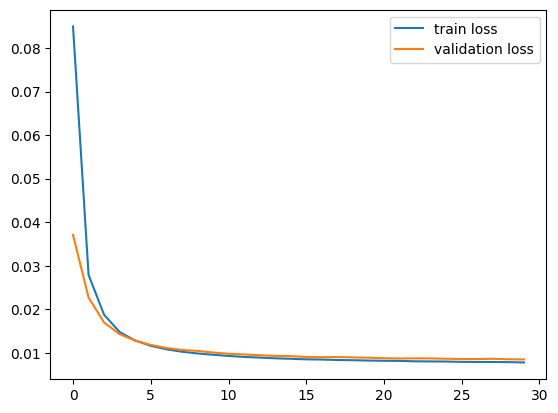

In [ ]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
WINDOW=2
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(40, return_state=False)(input_dinamic)
result_layer = Dense(13, activation='linear')(concatenate([lstm_layer, dense_layer]))
model = Model(name="StaticDense_DynamicLSTM_Window2", inputs=[input_static, input_dinamic], outputs=result_layer)
model.summary()
model.compile(optimizer="adam", loss="mse")

history = model.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=30)

show_results([S_val, D_val], y_val, model, history)

LSTM64_Window2

Model: "LSTM64_Window2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 64)                28672     
                                                                 
 dense_37 (Dense)            (None, 13)                845       
                                                                 
Total params: 29,517
Trainable params: 29,517
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
57/57 [==============================] - 3s 17ms/step - loss: 0.0428 - val_loss: 0.0176
Epoch 2/50
57/57 [==============================] - 0s 6ms/step - loss: 0.0146 - val_loss: 0.0135
Epoch 3/50
57/57 [==============================] - 0s 5ms/step - loss: 0.0121 - val_loss: 0.0118
Epoch 4/50
57/57 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 5/50
57/57 [==============================] -

INFO:tensorflow:Assets written to: models/LSTM64_Window2\assets


INFO:tensorflow:Assets written to: models/LSTM64_Window2\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001366,0.000504,0.001875,0.006852,0.000246,0.00118,0.004987,0.005353,0.008678,0.011383,0.055075,0.000684,0.003952
R2,0.001466,0.148505,0.453810,0.156121,0.189561,0.55853,0.711656,0.361910,0.528307,0.816302,0.110856,0.413783,0.671535


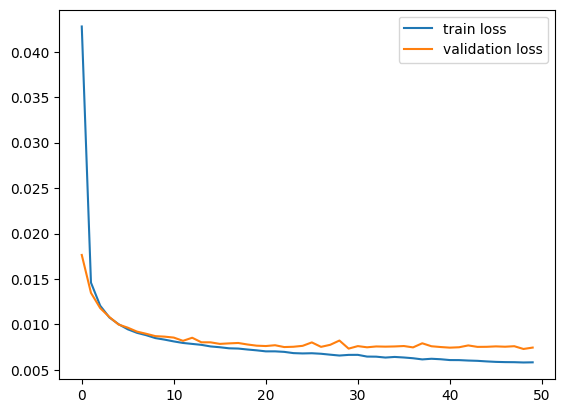

In [ ]:
PARAMS_LENGTH = X_train.shape[2]
TARGET_LENGTH = y_train.shape[1]
WINDOW=2
model = Sequential(name="LSTM64_Window2")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Window 3

In [ ]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = datacovid.prepare_data_with_static(df, window=3)
D_train, S_train, D_val, S_val, D_test, S_test = datacovid.divide_dynamic_static(X_train, X_test, X_val)
print("Test train shapes:", X_train.shape, X_test.shape)

Test train shapes: (712, 3, 47) (89, 3, 47)


Model: "LSTM64_Window2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 64)                28672     
                                                                 
 dense_38 (Dense)            (None, 13)                845       
                                                                 
Total params: 29,517
Trainable params: 29,517
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
23/23 [==============================] - 3s 42ms/step - loss: 0.0719 - val_loss: 0.0284
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0229 - val_loss: 0.0176
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0162 - val_loss: 0.0138
Epoch 4/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0135 - val_loss: 0.0121
Epoch 5/50
23/23 [==============================] 

INFO:tensorflow:Assets written to: models/LSTM64_Window2\assets


INFO:tensorflow:Assets written to: models/LSTM64_Window2\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001814,0.000804,0.010734,0.010420,0.001155,0.003335,0.005718,0.005051,0.006716,0.003378,0.050141,0.009507,0.004896
R2,-0.364156,0.384138,0.020281,-0.367185,-0.043635,-0.074149,0.578719,0.188155,0.620263,0.946272,0.212975,-0.001176,0.671687


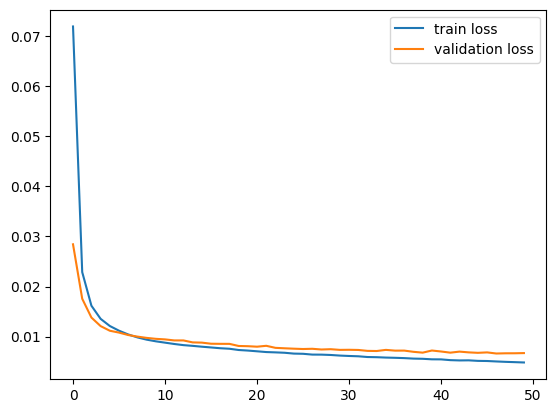

In [ ]:
PARAMS_LENGTH = X_train.shape[2]
TARGET_LENGTH = y_train.shape[1]
WINDOW=3
model = Sequential(name="LSTM64_Window2")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

In [ ]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = datacovid.prepare_data_with_static(df, window=4)
D_train, S_train, D_val, S_val, D_test, S_test = datacovid.divide_dynamic_static(X_train, X_test, X_val)
print("Test train shapes:", X_train.shape, X_test.shape)

Test train shapes: (288, 4, 47) (36, 4, 47)
